# COMP30850 - Assignment 1

**Student Number:** 20757091

In this assignment I will construct and analye network representations of two movie-related databases from IMDB. These networks will be created and inspected through five tasks:
1. Network Construction
1. Network Characterisation
3. Network Thresholding
4. Ego-centric Analysis
5. Network Visualisation

## Task 1: Network Construction

In [1]:
# importing necessary libraries
import networkx as nx
import pandas as pd
import json
import itertools
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# parsing two json files for assignment
json_file = open("20757091-dataset1.json","r")
network1 = json.load( json_file )
json_file.close()

json_file = open("20757091-dataset2.json","r")
network2 = json.load( json_file )
json_file.close()

For this assignment I will create a undirected weighted network. This is because all links between actors would be reciprocal as they each gain an edge weight respectively for every movie they co-star in. Weights will also be used on the edges between nodes to show how many times each actor has appeared alongside another.

In [3]:
network1

[{'id': '0000112',
  'name': 'Pierce Brosnan',
  'born': '1953-05-16',
  'movies': [{'id': '6443346',
    'title': 'Black Adam',
    'year': 2022,
    'kind': 'movie'},
   {'id': '2328678',
    'title': "The King's Daughter",
    'year': 2022,
    'kind': 'movie'},
   {'id': '10155932', 'title': 'Cinderella', 'year': 2021, 'kind': 'movie'},
   {'id': '10096842',
    'title': 'False Positive',
    'year': 2021,
    'kind': 'movie'},
   {'id': '4876134', 'title': 'The Misfits', 'year': 2021, 'kind': 'movie'},
   {'id': '10841088',
    'title': 'Riverdance: The Animated Adventure',
    'year': 2021,
    'kind': 'movie'},
   {'id': '8580274',
    'title': 'Eurovision Song Contest: The Story of Fire Saga',
    'year': 2020,
    'kind': 'movie'},
   {'id': '5254610', 'title': 'Final Score', 'year': 2018, 'kind': 'movie'},
   {'id': '6911608',
    'title': 'Mamma Mia! Here We Go Again',
    'year': 2018,
    'kind': 'movie'},
   {'id': '9307284',
    'title': 'The Pig on the Hill',
    'year'

In [4]:
network2

[{'id': '0000146',
  'name': 'Ralph Fiennes',
  'born': '1962-12-22',
  'movies': [{'id': '20112502',
    'title': 'Four Quartets',
    'year': 2022,
    'kind': 'movie'},
   {'id': '22033936',
    'title': 'National Theatre Live: Straight Line Crazy',
    'year': 2022,
    'kind': 'movie'},
   {'id': '9764362', 'title': 'The Menu', 'year': 2022, 'kind': 'movie'},
   {'id': '6856242', 'title': "The King's Man", 'year': 2021, 'kind': 'movie'},
   {'id': '2382320', 'title': 'No Time to Die', 'year': 2021, 'kind': 'movie'},
   {'id': '3696180', 'title': 'The Forgiven', 'year': 2021, 'kind': 'movie'},
   {'id': '3661210', 'title': 'The Dig', 'year': 2021, 'kind': 'movie'},
   {'id': '6673612', 'title': 'Dolittle', 'year': 2020, 'kind': 'movie'},
   {'id': '1984135', 'title': 'Coup 53', 'year': 2019, 'kind': 'movie'},
   {'id': '3513498',
    'title': 'The Lego Movie 2: The Second Part',
    'year': 2019,
    'kind': 'movie'},
   {'id': '5431890',
    'title': 'Official Secrets',
    'year'

**Network Structure**
- Both networks come in the form of a list
- In this list each actor is represented by a dictionary holding attributes of ID, Name, Born and Movies
- ID is an int, Name is a string, Born is the date the actor was born while Movies is another dictionary containing information regarding each movie the actor has appeared in such as ID, Title, Year and Kind
- This will have to be parsed to extract relevant information to allow for network construction

As I will be repeating steps to construct network 1 for network 2, I have written functions below to reduce overall code

In [5]:
# function to find names of actors who appear in dataset and return them in a list
def find_actor_names(network):
    names = []
    for act in network:
        name = act["name"]
        names += [name]
    return names

In [6]:
# function to find names of movies who appear in dataset and return them in a list
def find_movie_names(network):
    movie_names = []
    for act in network:
        for entry in act["movies"]:
            name = entry["title"]
            movie_names += [name]
    return movie_names

In [7]:
# function to find all movies for every actor who appears in dataset and return them in a dictionary format
# the actor will be the key and the movies they featured in will be the values

def create_actor_dict(network):
    actors_movies = {}
    for act in network:
        movies_for_actor = []
        for entry in act["movies"]:
            name = entry["title"]
            movies_for_actor += [name]
        actors_movies[act["name"]] = movies_for_actor
    return actors_movies

In [8]:
# function to use the dictionary created above to create a new dictionary which contains each movie as a key
# every actor that appeared in that movie will then be a value in a list
def create_movie_actor_dict(actor_dict):
    movie_actors = {}
    for actor in actor_dict:   ## for every actor in dataset
        for movie in actor_dict[actor]:
            if movie in movie_actors:
                movie_actors[movie].append(actor)
            
            else:
                movie_actors[movie] = []
                movie_actors[movie].append(actor)
    return movie_actors

In [9]:
# function to create a graph from a dictionary of movies and actors who appeared in them
def create_graph(movie_actors):
    g = nx.Graph()
    
    for movie in movie_actors:
        # if this is a new movie which only has one actor, add this actor as a node
        if (len(movie_actors[movie]) == 1) and (movie_actors[movie] not in g):
            g.add_node(movie_actors[movie][0])
        
        # otherwise look at combinations of actors for each movie and increase the weight if these actors already share an edge
        for pair in itertools.combinations(movie_actors[movie], r=2):
            if g.has_edge(pair[0], pair[1]):
                g[pair[0]][pair[1]]["weight"] += 1
            else:
                g.add_edge(pair[0], pair[1], weight=1)
    return g

In [10]:
# function using Counter to count and return all edge weights from a graph
def get_edge_weights(graph):
    weights = Counter()
    for entry in graph.edges(data=True):
        names = "%s, %s" % (entry[0], entry[1])
        weights[names] = entry[2]["weight"]
    return weights

### Network 1 Constuction

I will now use the functions created above to construct network 1

In [11]:
# creating list of actor names
actor_names = find_actor_names(network1)

In [12]:
# creating list of movie names
movie_names = find_movie_names(network1)

In [13]:
# creating dictionary of actors and each movie they appeared in
actor_dict = create_actor_dict(network1)

In [14]:
# creating dictionary of movies and each actor that appeared in it
movie_actor_dict = create_movie_actor_dict(actor_dict)

In [15]:
# constructing graph
graph1 = create_graph(movie_actor_dict)

In [16]:
isolated_nodes = list(nx.isolates(graph1))

In [17]:
# checking number of nodes and edges before removal of isolated nodes
print("Number of nodes: " + str(graph1.number_of_nodes()))
print("Number of edges: " + str(graph1.number_of_edges()))

Number of nodes: 191
Number of edges: 447


In [18]:
# looking at isolated nodes
print("Number of isolated nodes: " + str(len(isolated_nodes)))
print("\nIsolated nodes: " + str(isolated_nodes))

Number of isolated nodes: 29

Isolated nodes: ['Hiam Abbass', 'Danny Trejo', 'Ryôko Hirosue', 'Son Ye-jin', 'Rex Harrison', 'Debra Messing', 'Soha Ali Khan', 'Marlon Brando', 'Alec Guinness', 'Art Carney', 'Sarah Polley', 'Sissy Spacek', 'David Kelly', 'Lillete Dubey', 'Paprika Steen', 'John Goodman', 'Eddie Murphy', 'Steve Zahn', 'Julia Jentsch', 'Aidan Gillen', 'Seann William Scott', 'Goldie Hawn', 'Lee Marvin', 'Derek Luke', 'Broderick Crawford', 'Katharine Hepburn', 'Ginnifer Goodwin', 'Liam Cunningham', 'Lola Dueñas']


In [19]:
# removing isolated nodes
graph1.remove_nodes_from(isolated_nodes)

In [20]:
# checking number of nodes and edges after removal of isolated nodes
print("Number of nodes: " + str(graph1.number_of_nodes()))
print("Number of edges: " + str(graph1.number_of_edges()))

Number of nodes: 162
Number of edges: 447


There should be no self loops in this graph but the following step will remove them if that is the case

In [21]:
graph1.remove_edges_from(nx.selfloop_edges(graph1))

In [22]:
# checking number of nodes and edges after removal of self loops
print("Number of nodes: " + str(graph1.number_of_nodes()))
print("Number of edges: " + str(graph1.number_of_edges()))

Number of nodes: 162
Number of edges: 445


### Network 2 Constuction

In [23]:
# creating list of actor names
actor_names = find_actor_names(network2)

In [24]:
# creating list of movie names
movie_names = find_movie_names(network2)

In [25]:
# creating dictionary of actors and each movie they appeared in
actor_dict = create_actor_dict(network2)

In [26]:
# creating dictionary of movies and each actor that appeared in it
movie_actor_dict = create_movie_actor_dict(actor_dict)

In [27]:
# constructing graph
graph2 = create_graph(movie_actor_dict)

In [28]:
isolated_nodes = list(nx.isolates(graph2))

In [29]:
# checking number of nodes and edges before removal of isolated nodes
print("Number of nodes: " + str(graph2.number_of_nodes()))
print("Number of edges: " + str(graph2.number_of_edges()))

Number of nodes: 209
Number of edges: 428


In [30]:
# looking at isolated nodes
print("Number of isolated nodes: " + str(len(isolated_nodes)))
print("\nIsolated nodes: " + str(isolated_nodes))

Number of isolated nodes: 30

Isolated nodes: ['Cliff Robertson', 'Julie Delpy', 'Christopher Eccleston', 'Barbra Streisand', 'Chris Tucker', 'Megan Fox', 'Anna Faris', 'Liza Minnelli', 'Michael Cera', 'Marlee Matlin', 'Richie Stephens', 'Kati Outinen', 'Laurence Olivier', 'Gracy Singh', 'Michelle Monaghan', 'George C. Scott', 'Peter Coonan', 'Meg Ryan', 'Joe Nunez', 'Joan Allen', 'Nikolaj Coster-Waldau', 'Stuart Townsend', 'Rupert Grint', 'Geoffrey Rush', 'Juliane Köhler', 'Taraneh Alidoosti', 'Charlton Heston', 'Kang Hye-jeong', 'Mickey Rourke', 'Faye Dunaway']


In [31]:
# removing isolated nodes
graph2.remove_nodes_from(isolated_nodes)
# had slight issues with this isolated node not being removed later on
graph2.remove_node("Roberto Benigni")

In [32]:
# checking number of nodes and edges after removal of isolated nodes
print("Number of nodes: " + str(graph2.number_of_nodes()))
print("Number of edges: " + str(graph2.number_of_edges()))

Number of nodes: 178
Number of edges: 427


Once again checking and removing any potential self loops

In [33]:
graph2.remove_edges_from(nx.selfloop_edges(graph2))

In [34]:
# checking number of nodes and edges after removal of self loops
print("Number of nodes: " + str(graph2.number_of_nodes()))
print("Number of edges: " + str(graph2.number_of_edges()))

Number of nodes: 178
Number of edges: 423


## Task 2: Network Characterisation

This step involves first characterising the structure and connectivity of the network and then using centrality measures to identify important nodes. Similar to Task 1, I have created a few functions to be used on both networks

In [35]:
# function to plot the distribution of node degrees from graph alongside degree mean, median and range
def Node_Degree_Graph(graph):
    degrees = dict(graph.degree())
    degree_seq = pd.Series(degrees)
    print('Degree range: [%d, %d]' % (degree_seq.min(), degree_seq.max()))
    print('Mean degree: %.2f' % degree_seq.mean())
    print('Median degree: %d' % degree_seq.median())
    
    ax = degree_seq.plot.hist(figsize=(10,8), fontsize=12, legend=None, color="darkblue")
    ax.set_ylabel("Number of Nodes", fontsize=12)
    ax.set_xlabel("Degree", fontsize=12);

In [36]:
# function to plot edge weight distribution from graph and also print out the number of edge weights at each value
def Edge_Weight_Graph(graph):
    w = get_edge_weights(graph)
    plt.hist(w.values(), color="darkgreen", bins = 6)
    plt.show()
    print(Counter(w.values()))

In [37]:
# function to create and return a number of Centrality Measures that will be explained in detail when the function is called
# columns added are Node Degree, Degree Centrality, Betweeness Centrality, Closeness, Eigenvector and a Total Score which is
# the result of each row added together
def DataFrame_For_Graph(graph):
    degrees = dict(graph.degree())
    s = pd.Series(degrees)
    DF = pd.DataFrame(s,columns=["Node Degree"])
    
    deg = nx.degree_centrality(graph)
    DF["Degree Centrality"] = pd.Series(deg)
    
    bet = nx.betweenness_centrality(graph)
    DF["Betweeness Centrality"] = pd.Series(bet)
    
    close = nx.closeness_centrality(graph)
    DF["Closeness"] = pd.Series(close)
    
    eig = nx.eigenvector_centrality(graph)
    DF["Eigenvector"] = pd.Series(eig)
    
    DF["Total Score"] = DF["Degree Centrality"] + DF["Betweeness Centrality"] + DF["Closeness"] + DF["Eigenvector"]
    return DF

In [38]:
# function to return average for all values in Dataframe
def Dataframe_averages(DF):
    print("Average Degree Centrality: " + str(round(DF["Degree Centrality"].mean(), 3)))
    print("Average Betweeness Centrality: " + str(round(DF["Betweeness Centrality"].mean(), 3)))
    print("Average Closeness: " + str(round(DF["Closeness"].mean(), 3)))
    print("Average Eigenvector: " + str(round(DF["Eigenvector"].mean(), 3)))
    print("Average Total Score: " + str(round(DF["Total Score"].mean(), 3)))

### Network 1

#### a) Characterise Structure and Connectivity

Will start by first looking at the number of nodes and edges in network, followed by a small diagram of the network as it is currently

In [39]:
print("Number of nodes: " + str(graph1.number_of_nodes()))
print("Number of edges: " + str(graph1.number_of_edges()))

Number of nodes: 162
Number of edges: 445


Difficult to see much information from the graph below, apart from a large center which holds most of the nodes and some fewer components elsewhere

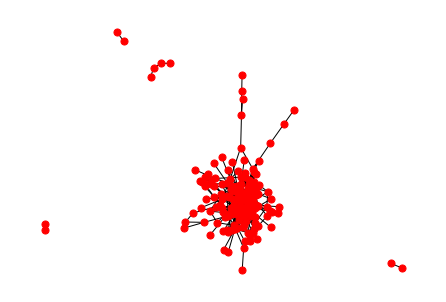

In [40]:
nx.draw(graph1, node_color='red', node_size=50)

As there are multiple components the graph is not connected i.e There is a path between every node. We can see five components which are each quite small apart from the main component

In [41]:
nx.is_connected(graph1)

False

In [42]:
nx.number_connected_components(graph1)

5

In [43]:
## checking length of each component in graph
for component in nx.connected_components(graph1):
    print(len(component))

152
2
2
4
2


Next we can look at network density - How many edges are there compared to the maximum number of possible edges

In [44]:
nx.density(graph1)

0.03412315006517905

Another way to check the connnectivity of network is by the average clustering - For each node this calculates the fraction of pairs of its neighbours that have edges between each other

In [45]:
nx.average_clustering(graph1)

0.23857211940000614

#### b) Centrality Measures

Using the functions created above we can look at the created networks in terms of Node Degree, Edge Weights and other Centrality Measures

Node Degree is how many other nodes does a node connect to

Degree range: [1, 17]
Mean degree: 5.49
Median degree: 5


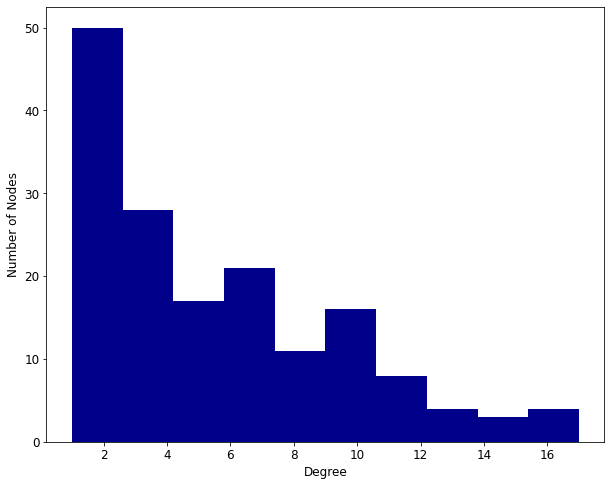

In [46]:
Node_Degree_Graph(graph1)

The Edge Weight is the number of times each node co-stars with another

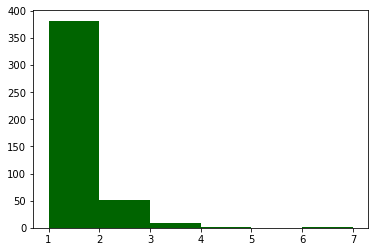

Counter({1: 382, 2: 51, 3: 9, 4: 2, 7: 1})


In [47]:
Edge_Weight_Graph(graph1)

In [48]:
DF_1 = DataFrame_For_Graph(graph1)

The dataframe which has been created has 6 columns:
- **Node Degree** - The number of edges ending at that node
- **Degree Centrality** - Normalising Node Degree by dividing by N-1 where N is the amount of nodes in the network
- **Betweeness Centrality** - Identifies important brokers in the network, influential nodes that control information dispersal
- **Closeness** - Measures extent to which a node is close to all other nodes in the network
- **Eigenvector** - Shows how important the nodes a node is connected to are
- **Total Score** - The result of every column bar Node Degree added together

In [49]:
DF_1

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Pierce Brosnan,6,0.037267,0.010960,0.303257,4.549584e-02,0.396980
William Hurt,13,0.080745,0.026753,0.352291,2.384387e-01,0.698228
Will Ferrell,5,0.031056,0.008127,0.296278,4.257918e-02,0.378041
Rachel McAdams,7,0.043478,0.021742,0.305877,4.148533e-02,0.412583
Cher,4,0.024845,0.006184,0.274460,1.245600e-02,0.317944
...,...,...,...,...,...,...
Patrick Wilson,1,0.006211,0.000000,0.239225,4.600058e-03,0.250036
Geraldine Page,1,0.006211,0.000000,0.009317,2.930555e-23,0.015528
Leonor Watling,1,0.006211,0.000000,0.143486,6.715142e-06,0.149704
Michelle Williams,1,0.006211,0.000000,0.236035,5.551371e-03,0.247798


When looking to find important nodes in our network, it depends on what we classify as important

If we value the number of connections a node has as the most important attribute we would use Degree Centrality and Degree value to decide this. This would give us with nodes:
- Scarlett Johansson
- Kenneth Branagh
- Josh Brolin

In [50]:
DF_1.sort_values(by="Node Degree",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Scarlett Johansson,17,0.105590,0.053240,0.371709,0.265161,0.795700
Kenneth Branagh,17,0.105590,0.070630,0.358534,0.216396,0.751151
Josh Brolin,17,0.105590,0.079394,0.380702,0.262895,0.828581
Chris Evans,16,0.099379,0.063285,0.353170,0.249986,0.765820
Oscar Isaac,15,0.093168,0.047017,0.373670,0.184787,0.698642


In [51]:
DF_1.sort_values(by="Degree Centrality",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Scarlett Johansson,17,0.105590,0.053240,0.371709,0.265161,0.795700
Kenneth Branagh,17,0.105590,0.070630,0.358534,0.216396,0.751151
Josh Brolin,17,0.105590,0.079394,0.380702,0.262895,0.828581
Chris Evans,16,0.099379,0.063285,0.353170,0.249986,0.765820
Oscar Isaac,15,0.093168,0.047017,0.373670,0.184787,0.698642


If control over transmission is important, we can sort by each node's Betweeness Centrality. Giving us important nodes of:
- Josh Brolin
- Kenneth Branagh
- Emily Blunt

In [52]:
DF_1.sort_values(by="Betweeness Centrality",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Josh Brolin,17,0.105590,0.079394,0.380702,0.262895,0.828581
Kenneth Branagh,17,0.105590,0.070630,0.358534,0.216396,0.751151
Emily Blunt,10,0.062112,0.068110,0.341256,0.059796,0.531274
Colin Firth,8,0.049689,0.063299,0.316826,0.038528,0.468342
Chris Evans,16,0.099379,0.063285,0.353170,0.249986,0.765820


If time taken to reach nodes is important, we can sort by Closeness Centrality. With top nodes of:
- Josh Brolin
- Oscar Isaac
- Scarlett Johansson

In [53]:
DF_1.sort_values(by="Closeness",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Josh Brolin,17,0.105590,0.079394,0.380702,0.262895,0.828581
Oscar Isaac,15,0.093168,0.047017,0.373670,0.184787,0.698642
Scarlett Johansson,17,0.105590,0.053240,0.371709,0.265161,0.795700
Taron Egerton,13,0.080745,0.061533,0.363131,0.123566,0.628975
Andy Serkis,15,0.093168,0.054305,0.360359,0.174508,0.682340


If influence of neighbours is important, we can sort by Eigenvector Centrality. Top nodes here are:
- Scarlett Johansson
- Josh Brolin	
- Chris Evans

In [54]:
DF_1.sort_values(by="Eigenvector",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Scarlett Johansson,17,0.105590,0.053240,0.371709,0.265161,0.795700
Josh Brolin,17,0.105590,0.079394,0.380702,0.262895,0.828581
Chris Evans,16,0.099379,0.063285,0.353170,0.249986,0.765820
Michelle Pfeiffer,12,0.074534,0.012585,0.350547,0.241995,0.679661
William Hurt,13,0.080745,0.026753,0.352291,0.238439,0.698228


Finally, we can sort by the Total Score column, which takes each of these 4 categories into account

In [55]:
DF_1.sort_values(by="Total Score",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Josh Brolin,17,0.105590,0.079394,0.380702,0.262895,0.828581
Scarlett Johansson,17,0.105590,0.053240,0.371709,0.265161,0.795700
Chris Evans,16,0.099379,0.063285,0.353170,0.249986,0.765820
Kenneth Branagh,17,0.105590,0.070630,0.358534,0.216396,0.751151
Oscar Isaac,15,0.093168,0.047017,0.373670,0.184787,0.698642


We can see many actors which were near the top of the other categories come to the top for Total Score

Due to this I would list the most important nodes in this network as:
- Josh Brolin
- Scarlett Johansson
- Chris Evans
- Kenneth Branagh
- William Hurt
- Michelle Pfeiffer
- Oscar Isaac

### Network 2

#### a) Characterise Structure and Connectivity

Will start by first looking at the number of nodes and edges in network, followed by a small diagram of the network as it is currently

In [56]:
print("Number of nodes: " + str(graph2.number_of_nodes()))
print("Number of edges: " + str(graph2.number_of_edges()))

Number of nodes: 178
Number of edges: 423


From the graph below we can see a main center of the network and two much smaller components also

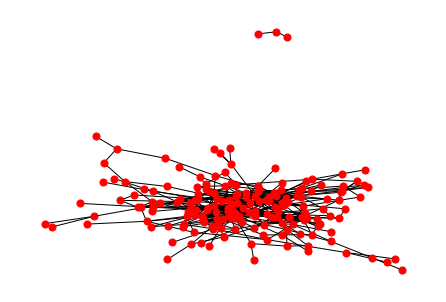

In [57]:
nx.draw(graph2, node_color='red', node_size=50)

As there are multiple components the graph is not connected i.e There is a path between every node. We can see one much smaller group away from the main component

In [58]:
nx.is_connected(graph2)

False

In [59]:
nx.number_connected_components(graph2)

2

In [60]:
## checking length of each component in graph
for component in nx.connected_components(graph2):
    print(len(component))

175
3


Next we can look at network density - How many edges are there compared to the maximum number of possible edges

In [61]:
nx.density(graph2)

0.0268520281851076

Another way to check the connnectivity of network is by the average clustering - For each node this calculates the fraction of pairs of its neighbours that have edges between each other

In [62]:
nx.average_clustering(graph2)

0.2437931918268996

#### b) Centrality Measures

Similar to for network 1 I will re-use the functions created above to look at netowrk 2 in terms of Node Degree, Edge Weights and other Centrality Measures

Node Degree is how many other nodes does a node connect to

Degree range: [1, 16]
Mean degree: 4.75
Median degree: 3


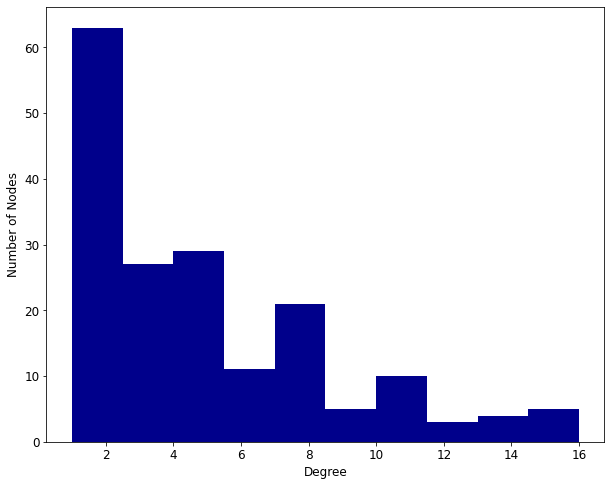

In [63]:
Node_Degree_Graph(graph2)

The Edge Weight is the number of times each node co-stars with another

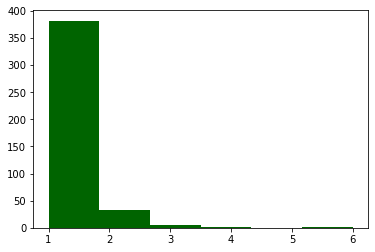

Counter({1: 382, 2: 32, 3: 5, 6: 2, 4: 2})


In [64]:
Edge_Weight_Graph(graph2)

In [65]:
DF_2 = DataFrame_For_Graph(graph2)

I will use the same basis as outlined in network 1 to analyze the Centrality Measures and created dataframe

The dataframe which has been created has 6 columns:
- **Node Degree** - The number of edges ending at that node
- **Degree Centrality** - Normalising Node Degree by dividing by N-1 where N is the amount of nodes in the network
- **Betweeness Centrality** - Identifies important brokers in the network, influential nodes that control information dispersal
- **Closeness** - Measures extent to which a node is close to all other nodes in the network
- **Eigenvector** - Shows how important the nodes a node is connected to are
- **Total Score** - The result of every column bar Node Degree added together

In [66]:
DF_2

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Ralph Fiennes,5,0.028249,0.018339,0.249345,0.008678,0.304610
Peter McDonald,1,0.005650,0.000000,0.199128,0.000968,0.205745
Jim Broadbent,7,0.039548,0.014300,0.274120,0.015606,0.343574
Marion Cotillard,8,0.045198,0.051889,0.297480,0.038589,0.433156
Emma Thompson,6,0.033898,0.013246,0.269796,0.020027,0.336967
...,...,...,...,...,...,...
Martin Lawrence,1,0.005650,0.000000,0.233676,0.006927,0.246252
Gene Hackman,3,0.016949,0.012673,0.256448,0.010753,0.296823
Clint Eastwood,1,0.005650,0.000000,0.203632,0.001199,0.210481
Tom Hardy,2,0.011299,0.001330,0.225959,0.009361,0.247949


When looking to find important nodes in our network, it depends on what we classify as important

If we value the number of connections a node has as the most important attribute we would use Degree Centrality and Degree value to decide this. This would give us with nodes:
- Benicio Del Toro
- Amy Adams
- Daisy Ridley

In [67]:
DF_2.sort_values(by="Node Degree",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Benicio Del Toro,16,0.090395,0.055268,0.360107,0.323416,0.829187
Amy Adams,16,0.090395,0.096790,0.357847,0.105359,0.650391
Daisy Ridley,15,0.084746,0.063509,0.349083,0.261245,0.758583
Adam Driver,15,0.084746,0.100735,0.367851,0.261247,0.814579
Timothée Chalamet,15,0.084746,0.086034,0.351234,0.213070,0.735084


In [68]:
DF_2.sort_values(by="Degree Centrality",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Benicio Del Toro,16,0.090395,0.055268,0.360107,0.323416,0.829187
Amy Adams,16,0.090395,0.096790,0.357847,0.105359,0.650391
Daisy Ridley,15,0.084746,0.063509,0.349083,0.261245,0.758583
Adam Driver,15,0.084746,0.100735,0.367851,0.261247,0.814579
Timothée Chalamet,15,0.084746,0.086034,0.351234,0.213070,0.735084


If control over transmission is important, we can sort by each node's Betweeness Centrality. Giving us important nodes of:
- Adam Driver
- Amy Adams
- Timothée Chalamet

In [69]:
DF_2.sort_values(by="Betweeness Centrality",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Adam Driver,15,0.084746,0.100735,0.367851,0.261247,0.814579
Amy Adams,16,0.090395,0.096790,0.357847,0.105359,0.650391
Timothée Chalamet,15,0.084746,0.086034,0.351234,0.213070,0.735084
Robert De Niro,11,0.062147,0.072922,0.342787,0.088282,0.566138
Vinnie Jones,9,0.050847,0.066183,0.314432,0.059431,0.490893


If time taken to reach nodes is important, we can sort by Closeness Centrality. With top nodes of:
- Adam Driver
- Benicio Del Toro
- Justin Theroux

In [70]:
DF_2.sort_values(by="Closeness",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Adam Driver,15,0.084746,0.100735,0.367851,0.261247,0.814579
Benicio Del Toro,16,0.090395,0.055268,0.360107,0.323416,0.829187
Justin Theroux,14,0.079096,0.064607,0.358597,0.263345,0.765645
Amy Adams,16,0.090395,0.096790,0.357847,0.105359,0.650391
Laura Dern,13,0.073446,0.041665,0.353411,0.282502,0.751025


If influence of neighbours is important, we can sort by Eigenvector Centrality. Top nodes here are:
- Benicio Del Toro	
- Laura Dern
- Lupita Nyong'o

In [71]:
DF_2.sort_values(by="Eigenvector",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Benicio Del Toro,16,0.090395,0.055268,0.360107,0.323416,0.829187
Laura Dern,13,0.073446,0.041665,0.353411,0.282502,0.751025
Lupita Nyong'o,12,0.067797,0.023402,0.340061,0.266600,0.697861
Justin Theroux,14,0.079096,0.064607,0.358597,0.263345,0.765645
Adam Driver,15,0.084746,0.100735,0.367851,0.261247,0.814579


Finally, we can sort by the Total Score column, which takes each of these 4 categories into account

In [72]:
DF_2.sort_values(by="Total Score",ascending=False).head(5)

,Node Degree,Degree Centrality,Betweeness Centrality,Closeness,Eigenvector,Total Score
Benicio Del Toro,16,0.090395,0.055268,0.360107,0.323416,0.829187
Adam Driver,15,0.084746,0.100735,0.367851,0.261247,0.814579
Justin Theroux,14,0.079096,0.064607,0.358597,0.263345,0.765645
Daisy Ridley,15,0.084746,0.063509,0.349083,0.261245,0.758583
Laura Dern,13,0.073446,0.041665,0.353411,0.282502,0.751025


Similar to as seen in network 1, many actors which were near the top of the other categories come to the top for Total Score

Due to this I would list the most important nodes in this network as:
- Benicio Del Toro
- Amy Adams
- Daisy Ridley
- Justin Theroux
- Laura Dern
- Timothée Chalamet
- Robert De Niro

### Network 1 vs. Network 2 Comparison

When comparing Networks we can start by comparing total nodes and edges. Network 1 has less nodes but more edges, potentially showing a denser network to Network 2

In [73]:
print("Network 1 Data")
print("Number of nodes: " + str(graph1.number_of_nodes()))
print("Number of edges: " + str(graph1.number_of_edges()))

Network 1 Data
Number of nodes: 162
Number of edges: 445


In [74]:
print("Network 2 Data")
print("Number of nodes: " + str(graph2.number_of_nodes()))
print("Number of edges: " + str(graph2.number_of_edges()))

Network 2 Data
Number of nodes: 178
Number of edges: 423


This can be confirmed by comparing their density scores. As seen below this was correct, Network 1 is denser than Network 2

In [75]:
nx.density(graph1)

0.03412315006517905

In [76]:
nx.density(graph2)

0.0268520281851076

Although the nodes and edges are quite similar, it will be interesting to look at the distribution of Node Degree and Edge Weights for each graph respectively

The Node Degree range is quite similar for each network, however network 1 has a higher mean and median degree 

Network 1

Degree range: [1, 17]
Mean degree: 5.49
Median degree: 5


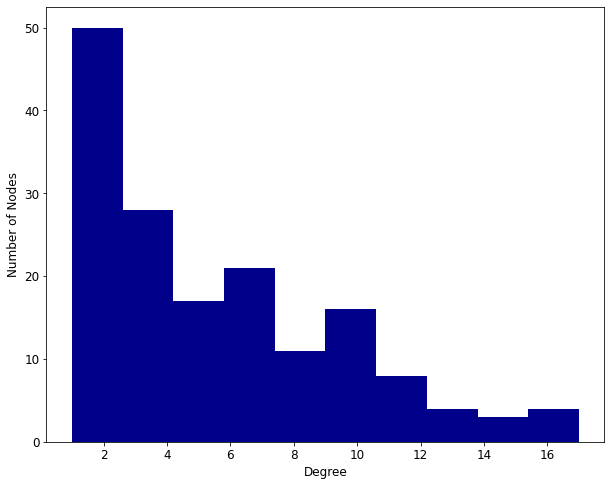

In [77]:
print("Network 1\n")
Node_Degree_Graph(graph1)

Network 2

Degree range: [1, 16]
Mean degree: 4.75
Median degree: 3


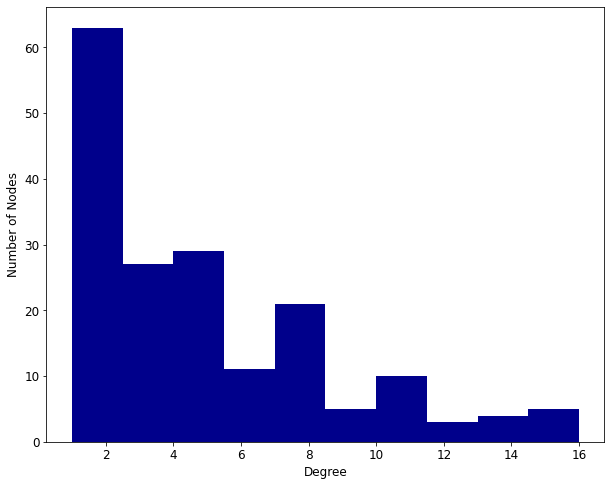

In [78]:
print("Network 2\n")
Node_Degree_Graph(graph2)

The two networks appear to have the same amount of edges with a weight score of 1. However after this the weights for network 2 drops off compared to network 1, mainly due to the lower amount of overall edges

Network 1


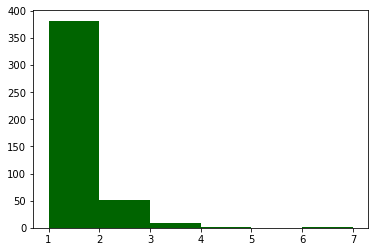

Counter({1: 382, 2: 51, 3: 9, 4: 2, 7: 1})


In [79]:
print("Network 1")
Edge_Weight_Graph(graph1)

Network 2


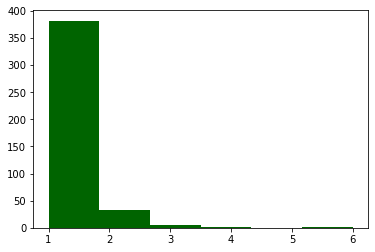

Counter({1: 382, 2: 32, 3: 5, 6: 2, 4: 2})


In [80]:
print("Network 2")
Edge_Weight_Graph(graph2)

We can also compare the two graphs in terms of their average clustering. From this it appears that network 2 has more nodes neighbours that have edges between each other

In [81]:
nx.average_clustering(graph1)

0.23857211940000614

In [82]:
nx.average_clustering(graph2)

0.2437931918268996

In terms of components, neither graph is connected. However, the number of components each network has differs. Network 2 has only 2 components compared to the 5 of network 1. The main component also has more nodes in it.

In [83]:
nx.number_connected_components(graph1)

5

In [84]:
for component in nx.connected_components(graph1):
    print(len(component))

152
2
2
4
2


In [85]:
nx.number_connected_components(graph2)

2

In [86]:
for component in nx.connected_components(graph2):
    print(len(component))

175
3


Finally, we can compare the average results returned by both Dataframes created to check the Centrality Measures of each network. The results are quite similar apart from Network 1 having a higher Degree Centrality which influenced the Total Score result. Excluding this most of the other results are close.

In [87]:
Dataframe_averages(DF_1)

Average Degree Centrality: 0.034
Average Betweeness Centrality: 0.013
Average Closeness: 0.268
Average Eigenvector: 0.05
Average Total Score: 0.365


In [88]:
Dataframe_averages(DF_2)

Average Degree Centrality: 0.027
Average Betweeness Centrality: 0.015
Average Closeness: 0.266
Average Eigenvector: 0.044
Average Total Score: 0.352


## Task 3: Network Thresholding

In [89]:
# function to apply threshold to graph
def apply_Threshold(graph, chosen_weight):
    new_graph = nx.Graph()
    for entry in graph.edges(data=True):
        if entry[2]["weight"] >= chosen_weight:
            new_graph.add_edge(entry[0], entry[1])
    return new_graph

In [90]:
# function to remove weights from a network
def Remove_weights(graph):
    for node, edges in nx.to_dict_of_dicts(graph).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)
    return graph

### Network 1

When deciding on how to choose threshold levels to apply to each network it makes sense to look at the current distribution of weights on the edges of each network

Network 1


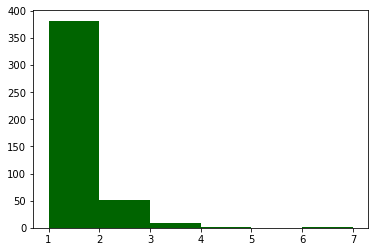

Counter({1: 382, 2: 51, 3: 9, 4: 2, 7: 1})


In [91]:
print("Network 1")
Edge_Weight_Graph(graph1)

From the graph above it makes most sense to choose threshold levels at 1, 2 and 3 as this is where the majority of edges come from

Will start by showing that we currently have a weighted network

In [92]:
nx.is_weighted(graph1)

True

In [93]:
print("Number of nodes: " + str(graph1.number_of_nodes()))
print("Number of edges: " + str(graph1.number_of_edges()))

Number of nodes: 162
Number of edges: 445


In [94]:
nx.number_connected_components(graph1)

5

#### Will start by removing weights less than 2

In [95]:
threshold_1 = apply_Threshold(graph1, 2)

Removing weights below two has a big impact on the structure of Network 1. The number of nodes drops by 103 and the number of edges drops dramatically from 445 to 63. The number of components also increases from 5 to 16 as the removal of nodes appears to have cut off certain links between components

In [96]:
print("Number of nodes: " + str(threshold_1.number_of_nodes()))
print("Number of edges: " + str(threshold_1.number_of_edges()))

Number of nodes: 59
Number of edges: 63


In [97]:
nx.number_connected_components(threshold_1)

16

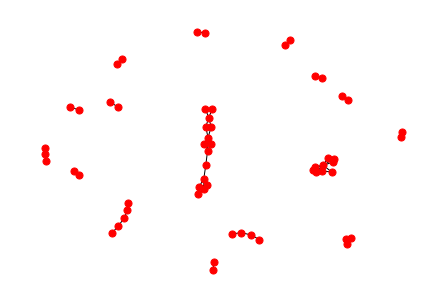

In [98]:
nx.draw(threshold_1, node_color='red', node_size=50)

#### Will now remove weights less than 3

In [99]:
threshold_2 = apply_Threshold(graph1, 3)

Upon removing weights below 3 our network shrinks even further, dropping to just 12 for node and edge count. However, the number of components drops greatly to just 3

In [100]:
print("Number of nodes: " + str(threshold_2.number_of_nodes()))
print("Number of edges: " + str(threshold_2.number_of_edges()))

Number of nodes: 12
Number of edges: 12


In [101]:
nx.number_connected_components(threshold_2)

3

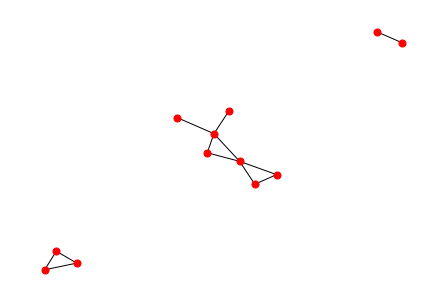

In [102]:
nx.draw(threshold_2, node_color='red', node_size=50)

#### Will finally remove weights less than 4

In [103]:
threshold_3 = apply_Threshold(graph1, 4)

When implementing the final threshold and removing weights below 4, the network is down to just one component which contains 3 nodes and 3 edges

In [104]:
print("Number of nodes: " + str(threshold_3.number_of_nodes()))
print("Number of edges: " + str(threshold_3.number_of_edges()))

Number of nodes: 3
Number of edges: 3


In [105]:
nx.number_connected_components(threshold_3)

1

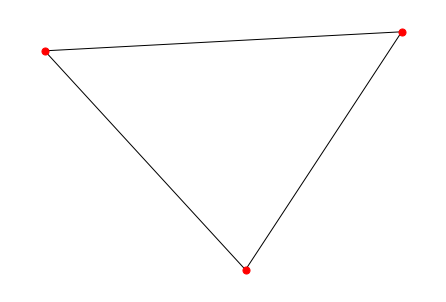

In [106]:
nx.draw(threshold_3, node_color='red', node_size=50)

### Network 2

When deciding on how to choose threshold levels to apply to each network it makes sense to look at the current distribution of weights on the edges of each network

Network 2


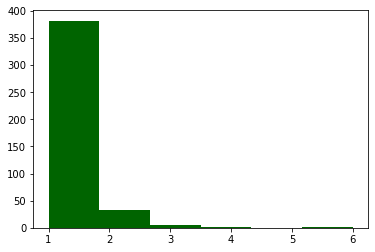

Counter({1: 382, 2: 32, 3: 5, 6: 2, 4: 2})


In [107]:
print("Network 2")
Edge_Weight_Graph(graph2)

From the graph above it makes most sense to choose threshold levels at 1, 2 and 3 as this is where the majority of edges come from - Similar to Network 1

Will start by showing that we currently have a weighted network

In [108]:
nx.is_weighted(graph2)

True

In [109]:
print("Number of nodes: " + str(graph2.number_of_nodes()))
print("Number of edges: " + str(graph2.number_of_edges()))

Number of nodes: 178
Number of edges: 423


In [110]:
nx.number_connected_components(graph2)

2

#### Will start by removing weights less than 2

In [111]:
threshold_1 = apply_Threshold(graph2, 2)

Removing weights below two also has a big impact on the structure of Network 2. The number of nodes drops by 135 and the number of edges drops dramatically from 423 to 41. The number of components also increases from 2 to 12 as the removal of nodes appears to have cut off certain links between components

In [112]:
print("Number of nodes: " + str(threshold_1.number_of_nodes()))
print("Number of edges: " + str(threshold_1.number_of_edges()))

Number of nodes: 43
Number of edges: 41


In [113]:
nx.number_connected_components(threshold_1)

12

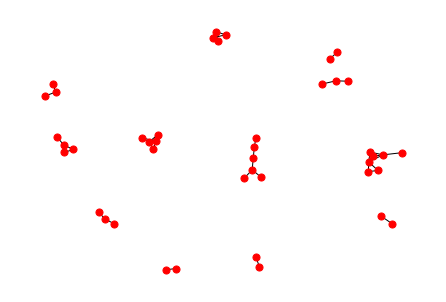

In [114]:
nx.draw(threshold_1, node_color='red', node_size=50)

#### Will now remove weights less than 3

In [115]:
threshold_2 = apply_Threshold(graph2, 3)

Upon removing weights below 3 our network shrinks even further, dropping to just 14 for node and 9 for edge count. However, the number of components drops from 12 to 6

In [116]:
print("Number of nodes: " + str(threshold_2.number_of_nodes()))
print("Number of edges: " + str(threshold_2.number_of_edges()))

Number of nodes: 14
Number of edges: 9


In [117]:
nx.number_connected_components(threshold_2)

6

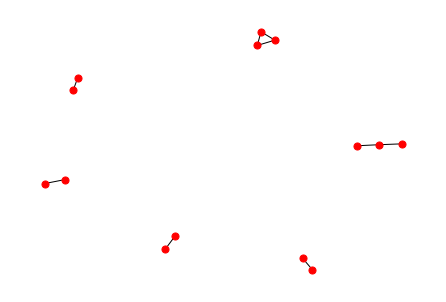

In [118]:
nx.draw(threshold_2, node_color='red', node_size=50)

#### Will finally remove weights less than 4

In [119]:
threshold_3 = apply_Threshold(graph2, 4)

Unlike as in Network 1, removing weights below 4 does not result in one final connected component. The network is now made up of 7 nodes and 4 edges, which result in 3 seperate connected components

In [120]:
print("Number of nodes: " + str(threshold_3.number_of_nodes()))
print("Number of edges: " + str(threshold_3.number_of_edges()))

Number of nodes: 7
Number of edges: 4


In [121]:
nx.number_connected_components(threshold_3)

3

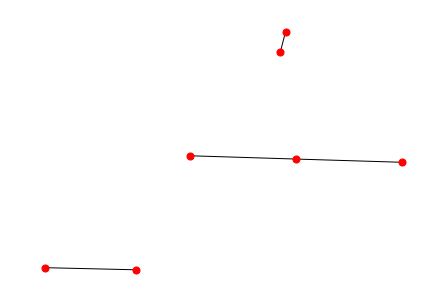

In [122]:
nx.draw(threshold_3, node_color='red', node_size=50)

## Task 4: Ego-centric Analysis

In [123]:
# function to graph and give information on ego node
def display_ego(graph, ego_node):
    # build the ego network
    ego = nx.ego_graph(graph, ego_node)
    # create the figure
    plt.figure(figsize=(10,8))
    title = "Ego network for %s (%d nodes)" % (ego_node, ego.number_of_nodes())
    plt.title(title, fontsize=16)
    # lay out all nodes
    pos = nx.spring_layout(graph)
    # draw the full network
    nx.draw_networkx(ego, pos, with_labels=True, font_size=10, node_size=600, node_color="lightgreen")
    # draw the ego in red, with larger node size
    nx.draw_networkx_nodes(ego, pos, nodelist=[ego_node], node_size=2500, node_color="lightblue")
    plt.axis("off")
    return ego

### Network 1

As shown in Task 2, the imporant nodes in Network 1 are:
- Josh Brolin
- Scarlett Johansson
- Chris Evans
- Kenneth Branagh
- William Hurt
- Michelle Pfeiffer
- Oscar Isaac

The node I have chosen to create an ego Network for is **Josh Brolin**

This is due to the fact that this node achieved the highest score for Betweeness Centrality and Closeness, while also being top in the self constructed Total Score column

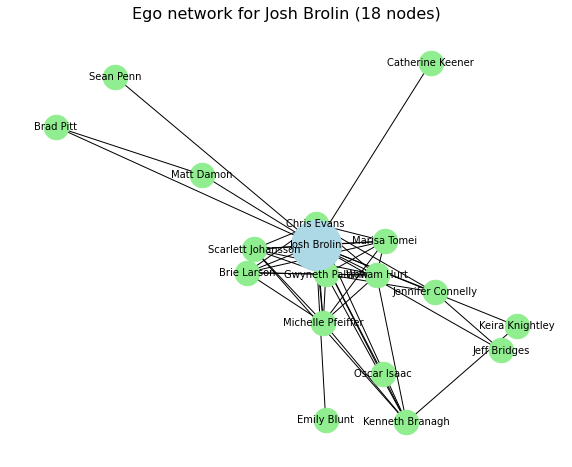

In [124]:
ego = display_ego(graph1, "Josh Brolin")

In [125]:
print("Nodes in ego network: " + str(ego.number_of_nodes()))
print("Edges in ego network: " + str(ego.number_of_edges()))

Nodes in ego network: 18
Edges in ego network: 48


In [126]:
nx.density(ego)

0.3137254901960784

In [127]:
nx.average_clustering(ego)

0.6665434692395477

### Network 2

As shown in Task 2, the imporant nodes in Network 2 are:
- Benicio Del Toro
- Amy Adams
- Daisy Ridley
- Justin Theroux
- Laura Dern
- Timothée Chalamet
- Robert De Niro

The node I have chosen to create an ego Network for is **Benicio Del Toro**

This is due to the fact that this node achieved the highest score for Degree Centrality and Eigenvector, while also being top in the self constructed Total Score column

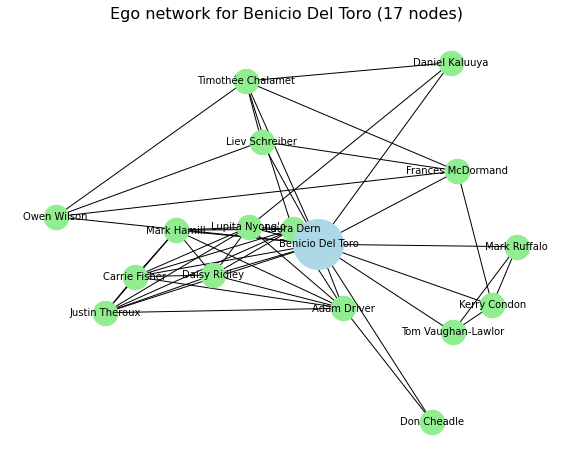

In [128]:
ego = display_ego(graph2, "Benicio Del Toro")

In [129]:
print("Nodes in ego network: " + str(ego.number_of_nodes()))
print("Edges in ego network: " + str(ego.number_of_edges()))

Nodes in ego network: 17
Edges in ego network: 51


As seen below, our chosen node for Network 2 has a higher density and average clustering for its ego network

In [130]:
nx.density(ego)

0.375

In [131]:
nx.average_clustering(ego)

0.8362044817927171

## Task 5: Network Visualisation

Networks are written out as GEXF files. These files will be used with Gephi to produce visualisations of each network. The visualisations will be contained in ZIP file along with this document. The images provided for each network show Node Degree resulting in a larger node size and thicker lines showing stronger edge weights

In [132]:
nx.write_gexf(graph1, "Assignment1-Graph1.gexf", prettyprint=True)
nx.write_gexf(graph2, "Assignment1-Graph2.gexf", prettyprint=True)